# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [574]:
# Parameters
m = 3
A = 0.1#0.1449

0.1

In [575]:
res=m;
N=2.0^m*100.0#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10#100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 4.0


In [576]:
print(N)

800.0

In [577]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.00125
dt =0.0005
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [578]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3"

In [579]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [580]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [581]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.00125
the time step is 0.0005


In [582]:
include("./ScalarField.jl");

In [583]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [584]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
"""for i in 4:L-3
    initderpsi[i]=Der(state_array[:,:],i,3,initX)
end

state_array[:,4] = initderpsi
state_array = ghost(state_array)"""

#new
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], initderpsi[4:L-3],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

funcs = [psi_func derpsi_func]

1×2 Matrix{Function}:
 psi_func  derpsi_func

In [585]:
#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,funcs)
state_array[:,1]=initm;
state_array = ghost(state_array);

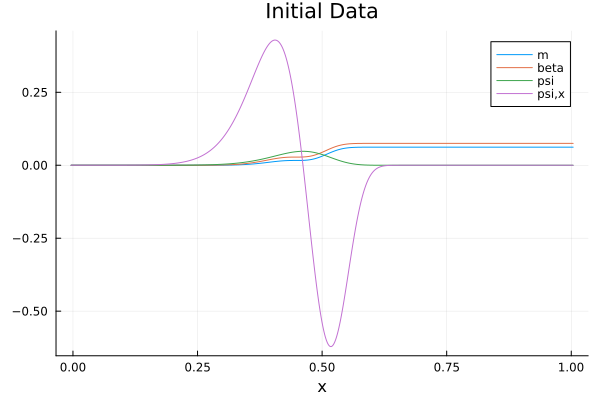

In [586]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[-0.001, 0.001])"""

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [587]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3/time_step0.csv"

In [588]:
timestep=0
criticality=false
explode=false
critical_stop=0
evol_stats = [criticality A sigma r0 timestep explode]
monitor_ratio = zeros(L)
CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "timestep", "explode"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

 ## Time evolution

fixed grid

In [589]:
using Interpolations
using ProgressMeter
@showprogress for t in 1:10#length(T)
    
    if isnan(state_array[L-3,4])
        print("boom")
        explode = true
        timestep = t
        break
    end
    
    
    X=initX #state_array[:,5]
    X1=X[4:L-3]

    #update ghost points
    #state_array=boundarySF(state_array,X)
   
    #evolve psi,x
    global state_array[:,1:4] = rungekutta4molstep(SF_RHS,state_array[:,1:4],T,t,0,initX) #evolve psi,x
    global state_array=ghost(state_array)

    #global aux=SF_RHS(state_array[:,:], 0,0,X)
    
    #calculate psi from psi,x
    global spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=4)
    psi0=0
    SFconstraint_psi(psi0,x) = scipyinterpolate.splev(x, spl_derpsi)

    global state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,initX1)
    global state_array=ghost(state_array);

    global spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
    global psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    global derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

    global funcs = [psi_func derpsi_func]
    
    #evolve beta
    global state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T[t+1],funcs)
    global state_array=ghost(state_array)
    
    #evolve m
    global state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,T[t+1],funcs)
    global state_array=ghost(state_array)
    
    #CSV.write(dir*"/time_step$k.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
    CSV.write(dir*"/time_step$t.csv", Tables.table(state_array), writeheader=false)
    
    
    #threshold for apparent black hole formation
    """global monitor_ratio = zeros(L)
    for i in 1:L
        global monitor_ratio[i] = 2*state_array[i,1]/initX[i]*(1-initX[i])
        if monitor_ratio[i]>0.6
            global criticality = true
            println("Supercritical evolution!")
            println("i = ", i, " t = ", t, " monitor ratio = ", monitor_ratio[i])
            critical_stop += 1
            timestep = t
        end
    end
    
    if critical_stop >=15
        print("Found apparent horizon formation")
        timestep = t
        break
    end"""
    timestep = t
end


global evol_stats = [criticality A sigma r0 timestep explode]

CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true,header=["criticality", "A", "sigma", "r0", "timestep", "explode"])

#CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(transpose(Array(monitor_ratio))), delim = ';', writeheader=false, append=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [357]:
#aux2 = range(1,10,step=0.01/2)

In [358]:
#spl2 = scipyinterpolate.splrep(aux2, sin.(aux2),k=2)
func2 = cubic_spline_interpolation(x2, var2,  extrapolation_bc = Line());
#func2(x) = scipyinterpolate.splev(x, spl2)



LoadError: UndefVarError: x2 not defined

In [494]:
#aux4 = range(1,10,step=0.01/4)
#spl4 = scipyinterpolate.splrep(aux4, sin.(aux4),k=2)
func4 = cubic_spline_interpolation(x4, var4,  extrapolation_bc = Line());
#func4(x) = scipyinterpolate.splev(x, spl4)

In [508]:
using Plots #showing initial data and the initial status of the horizon finder
plotlyjs()
aux_test = range(0,1,step=0.001)

#plot(aux, [(abs.(func4(aux).-func2(aux))) abs.(func2(aux).-func(aux))], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0, 1])#,ylim=[0.001 1*10])
scatter(x4, [abs.((func4(x4).-func2(x4)))*16 abs.(func2(x4).-func(x4))], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0, 1])#,ylim=[0.001 1*10])



In [502]:
[x1 x2[1:2:length(x2)] x4[1:4:length(x4)]]

21×3 Matrix{Float64}:
 0.0   0.0   0.0
 0.05  0.05  0.05
 0.1   0.1   0.1
 0.15  0.15  0.15
 0.2   0.2   0.2
 0.25  0.25  0.25
 0.3   0.3   0.3
 0.35  0.35  0.35
 0.4   0.4   0.4
 0.45  0.45  0.45
 0.5   0.5   0.5
 0.55  0.55  0.55
 0.6   0.6   0.6
 0.65  0.65  0.65
 0.7   0.7   0.7
 0.75  0.75  0.75
 0.8   0.8   0.8
 0.85  0.85  0.85
 0.9   0.9   0.9
 0.95  0.95  0.95
 1.0   1.0   1.0

In [33]:
func(aux_test).-func2(aux_test)

101-element Vector{Float64}:
 -2.168404344971009e-19
  0.0
  6.938893903907228e-18
  1.3877787807814457e-17
 -1.3877787807814457e-17
  0.0
 -2.7755575615628914e-17
  5.551115123125783e-17
  2.7755575615628914e-17
  0.0
  5.551115123125783e-17
 -5.551115123125783e-17
  0.0
  ⋮
  5.551115123125783e-17
 -5.551115123125783e-17
 -5.551115123125783e-17
  5.551115123125783e-17
  5.551115123125783e-17
  0.0
  0.0
 -5.551115123125783e-17
  2.7755575615628914e-17
  2.7755575615628914e-17
  2.7755575615628914e-17
  0.0

In [519]:
T=collect(T)
T[8]

0.00035

In [498]:
T[7]

0.0006

In [499]:
T[8]-T[7]

0.00010000000000000005

In [500]:
round(T[8]-T[7],digits=8)

0.0001

## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
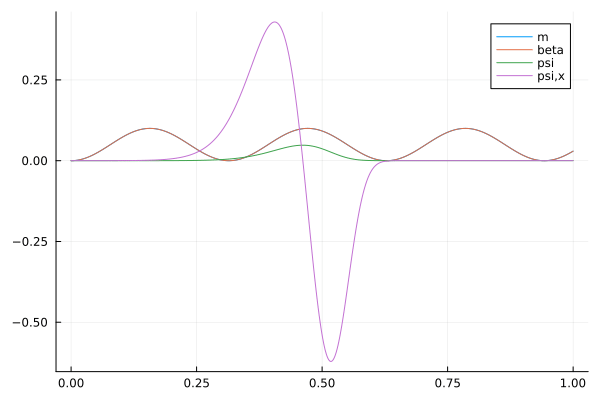

In [510]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:10#00:2:length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(initX[4:L-3], [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.9 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)

changing grid

In [ ]:
"using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve grid
    X=update_grid(state_array,dx,T,k,spl_funcs)
    state_array[:,5]=X
    L=length(X)
    X1=X[4:L-3]
    
    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0) #evolve psi,x
    state_array=ghost(state_array,X)
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array,X);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array,X)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=m_rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array,X)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end"

In [ ]:
print(dir)

In [ ]:
"""#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio[i] = 2*state_array[i,1]/initX[i]*(1-initX[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end"""